# Regresiones con salidas enteras

Los GLMs guardan cierta relación con los modelos lineales Gaussianos, sin embargo, una gran diferencia es que la escala de los parámetros no es la misma de la variable de resultado. De hecho, la relación entre los parámetros y la variable de resultado es no lineal lo que hace complejo interpretar y entender los parámetros. En este sentido, comprender y dominar las GLMs es algo más complejo.

Los GLMs más comunes y útiles son modelos de cuentas (enteros no negativos). Sin embargo, también son modelos que pueden tornarse bastante complicados. EL problema radica en lo siguiente:

> Si lo que queremos predecir es una cuenta, la escala de los parámetros nunca es la escala de la salida.

> **Objetivos:**
> - Comprender los modelos de regresión binomial.

> **Referencias:**
> 
> - Statistical Rethinking: A Bayesian Course with Examples in R and Stan (2nd edition) - Richard McElreath.


## 1. Regresión binomial

Si volvemos a los módulos más fundamentales del curso, recordaremos que muchos de los ejemplos iniciales correspondían al tiro de una moneda. Como hemos visto, la moneda no es más que un caso especial de un fenómeno con dos posibilidades (presencia o ausencia de una característica de interés). Cuando en este tipo de fenómenos, estamos interesados en la cantidad de veces que la moneda cae cara (presencia de la característica), modelamos la variable como:

$$
y \sim \text{Binomial}(n, p),
$$

donde $y$ es una cuenta, $p$ es la probabilidad de que la moneda caiga cara (presencia de la característica), y $n$ es e número de tiros. Este no es aún un GLM, dado que no tenemos ningún predictor.

Hay dos tipos de GLM que usan funciones de probabilidad binomial:

- **Regresión logística**: es la más común, y sucede cuando $n=1$, de forma que la variable de respuesta solo puede valer $0$ o $1$.
- Cuando $n \geq 1$, hablamos de una **regresión binomial agregada**. En este caso, la variable de respuesta puede tomar cualquier valor entre cero ($0$) y hasta $n$.

Es importante mencionar que ambos tipos de GLM usan el enlace logit que vimos en el notebook pasado, por lo que aveces se les llama a ambos regresión logística.

### Regresión logística

Construiremos a partir de un ejemplo usando datos de un experimento con el objetivo de evaluar las tendencias sociales de los chimpacés.

- Un chimpacé focal se sienta al final de una mesa larga con dos palancas, una a la izquierda y otra a la derecha.
- En la mesa hay cuatro platos con comida:
    - Los dos platos en el lado derecho de la mesa están atados a la palanca derecha por un mecanismo.
    - Los dos platos del lado izquierdo están atadso similarmente a la palanca izquierda
- Cuando alguna de las palancas se levanta por el animal focal, los dos platos del lado de la palanca que se levantó se deslizan hacia lados opuestos de la mesa.
- En todos los experimentos, ambos platos del lado del animal focal contienen comida.
- Pero solo un plato del otro lado contiene comida.
- Por tanto, mientras ambas palancas aseguran comida para el animal focal, solo una dará comida al animal del otro lado de la mesa.

Tenemos dos situaciones. En la condición *partner*, otro chimpancé es sentado al lado opuesto de la mesa. En la condición de control, el lado opuesto de la mesa está vacío. Finalmente, se alterna el lado de la mesa, derecha o izquierda, en que se ubica el plato con comida para el lado opuesto al animal focal. Esto ayuda a eliminar cualquier preferencia de mano del animal focal.

En experimentos hechos con humanos, casi siempre se elige la opción que entrega comida al otro lado de la mesa, siempre que halla alguien sentado allí. La pregunta acá es si el chimpancé focal se comporta de manera similar.

In [1]:
# Importamos pandas
import pandas as pd

In [4]:
# Leemos los datos
chimp_data = pd.read_csv("data/chimpanzees.csv", sep=";")
# Cambiamos la variable actor para que comience en cero
chimp_data["actor"] -= 1

In [5]:
chimp_data["actor"].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [6]:
chimp_data

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,0,NaN,0,1,2,0,1,0
1,0,NaN,0,1,4,0,0,1
2,0,NaN,0,1,6,1,0,0
3,0,NaN,0,1,8,0,1,0
4,0,NaN,0,1,10,1,1,1
...,...,...,...,...,...,...,...,...
499,6,4.0,1,6,64,1,1,1
500,6,6.0,1,6,66,1,1,1
501,6,3.0,1,6,68,0,0,1
502,6,7.0,1,6,70,0,0,1


Nos enfocaremos en la variable `pulled_left` como variable de respuesta, usando las variables `prosoc_left` y `condition` como predictores. Todas estas variables son binarias, donde:

- `pulled_left` en $1$ indica que el animal focal levantó la palanca de la izquierda.
- `prosoc_left` en $1$ indica que la comida para el animal del otro extremo estaba atada a la palanca izquierda (opción prosocial a la izquierda).
- `condition` en $1$ indica que había un animal del lado opuesto de la mesa.

Queremos inferir qué pasa para cada combinación:

| `prosoc_left` | `condition` | Explicación:                                          |
| ------------- | ----------- | ----------------------------------------------------- |
|       0       |      0      | Dos elementos de comida a la derecha, sin compañero   |
|       1       |      0      | Dos elementos de comida a la izquierda, sin compañero |
|       0       |      1      | Dos elementos de comida a la derecha, con compañero   |
|       1       |      1      | Dos elementos de comida a la izquierda, con compañero |

Como ya vimos, lo mejor en este caso es construir una variable indizadora. Podemos hacer lo siguiente:

In [7]:
# Variable de tratamiento
chimp_data["treatment"] = chimp_data["prosoc_left"] + 2 * chimp_data["condition"]
# Verificamos
chimp_data.groupby(by=["treatment"]).agg("first")[["prosoc_left", "condition"]]

,prosoc_left,condition
treatment,,
0,0,0
1,1,0
2,0,1
3,1,1


Con este preprocesamiento, estamos listos para revisar nuestro modelo:

$$
\begin{array}{rcl}
L_i & \sim & \text{Binomial}(1, p_i) \\
\text{logit}(p_i) & = & \alpha_{\text{actor}[i]} + \beta_{\text{treatment}[i]} \\
\alpha_j & \sim & \text{tbd} \\
\beta_k & \sim & \text{tbd}
\end{array}
$$

donde $L$ es simplemente una variable que indica si se jaló o no la palanca izquierda. Dado que esta variable es binaria, muchas veces se define el modelo como:

$$
L_i \sim \text{Bernoulli}(p_i),
$$

lo que es equivalente. En cualquier caso, tenemos $7$ $\alpha$'s y $4$ $\beta$'s, las cuales tenemos que definir.

Es muy importante en este momento retomar la idea de simulación previa predictiva para la elección de las previas. Para esto, consideremos el modelo anterior con un solo parámetro $\alpha$:

$$
\begin{array}{rcl}
L_i & \sim & \text{Binomial}(1, p_i) \\
\text{logit}(p_i) & = & \alpha \\
\alpha & \sim & \text{Normal}(0, \omega)
\end{array}
$$

con $\omega > 0$.

Comencemos con una previa plana $\omega=10$:

In [8]:
# Importar pymc
import pymc as pm
# Importar arviz
import arviz as az

/home/esteban/anaconda3/envs/stat-rethink2-pymc_v4/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [17]:
# Modelo con un solo parámetro
with pm.Model() as simple_model:
    a = pm.Normal("a", 0, 10)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    L = pm.Bernoulli(
        "pulled_left",
        p,
        observed=chimp_data["pulled_left"].values
    )

    prior_sample = pm.sample_prior_predictive()

Sampling: [a, pulled_left]


In [18]:
# Importar pyplot
from matplotlib import pyplot as plt

Text(0, 0.5, 'Density')

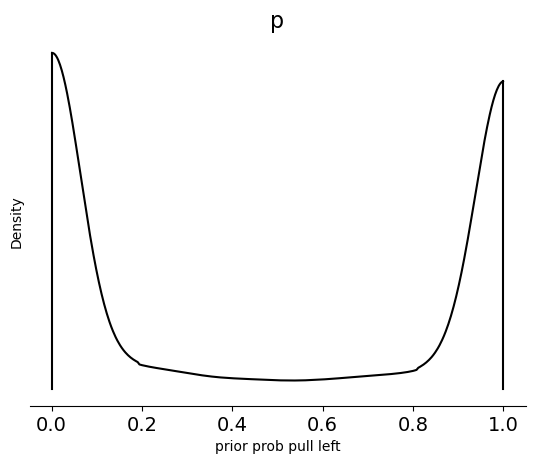

In [19]:
# Graficamos densidad de p
az.plot_density(
    prior_sample["prior"],
    group="prior",
    colors=["k"],
    var_names=["p"],
    point_estimate=None,
)
plt.xlabel("prior prob pull left")
plt.ylabel("Density")

Notemos que la masa de probabilidad se concentra en $0$ y $1$. Es decir, el modelo piensa (antes de ver los datos) que los chimpancés siempre jalarán la palanca, o nunca lo harán.

Ahora con $\omega = 1.5$:

In [20]:
# Modelo con un solo parámetro
with pm.Model() as simple_model_2:
    a = pm.Normal("a", 0, 1.5)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    L = pm.Bernoulli(
        "pulled_left",
        p,
        observed=chimp_data["pulled_left"].values
    )

    prior_sample_2 = pm.sample_prior_predictive()

Sampling: [a, pulled_left]


Text(0, 0.5, 'Density')

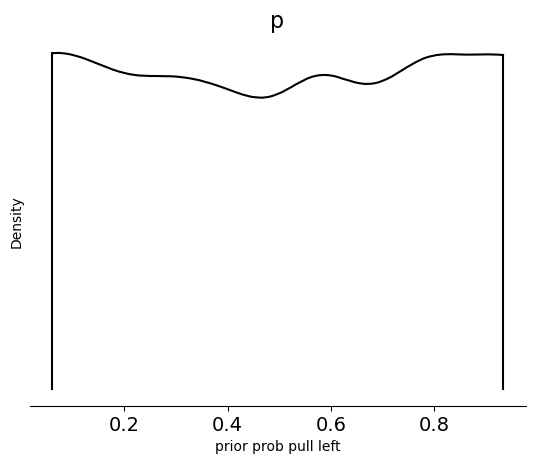

In [21]:
# Graficamos densidad de p
az.plot_density(
    prior_sample_2["prior"],
    group="prior",
    colors=["k"],
    var_names=["p"],
    point_estimate=None,
)
plt.xlabel("prior prob pull left")
plt.ylabel("Density")

Mucho mejor.

Ahora necesitamos determinar la previa para el efecto del tratamiento $\beta$. Hagamos el mismo experimento que antes:

In [22]:
# Importar scipy.special.expit as logistic
from scipy.special import expit as logistic
# Importar numpy
import numpy as np

In [23]:
# Modelo
with pm.Model() as simple_model_3:
    a = pm.Normal("a", 0, 1.5)
    b = pm.Normal("b", 0, 10, shape=4)
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(a + b[chimp_data["treatment"].values])
    )
    L = pm.Bernoulli(
        "pulled_left",
        p,
        observed=chimp_data["pulled_left"].values
    )

    prior_sample_3 = pm.sample_prior_predictive()

Sampling: [a, b, pulled_left]


En este caso tenemos una $\beta$ para cada uno de los tratamientos:

| `prosoc_left` | `condition` | Explicación:                                          |
| ------------- | ----------- | ----------------------------------------------------- |
|       0       |      0      | Dos elementos de comida a la derecha, sin compañero   |
|       1       |      0      | Dos elementos de comida a la izquierda, sin compañero |
|       0       |      1      | Dos elementos de comida a la derecha, con compañero   |
|       1       |      1      | Dos elementos de comida a la izquierda, con compañero |

Podemos obtener las $p$ correspondientes a cada tratamiento y evaluar su diferencia:

array([[<Axes: title={'center': 'x'}>]], dtype=object)

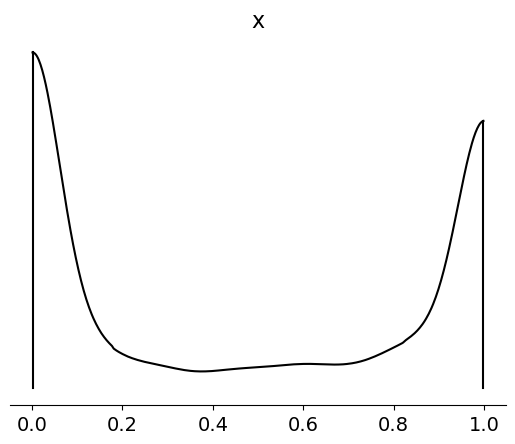

In [25]:
p_treat0, p_treat1 = (
    logistic(prior_sample_3["prior"]["a"] + prior_sample_3["prior"]["b"].sel(b_dim_0=0)),
    logistic(prior_sample_3["prior"]["a"] + prior_sample_3["prior"]["b"].sel(b_dim_0=1)),
)

az.plot_density(
    np.abs(p_treat0 - p_treat1).values,
    group="prior",
    colors=["k"],
    point_estimate=None
)

Igual que antes, con la previa plana, obtenemos concentración de masa de probabilidad en $0$ y $1$. Ahora intentemos con $\omega=0.5$:

In [26]:
# Modelo
with pm.Model() as simple_model_4:
    a = pm.Normal("a", 0, 1.5)
    b = pm.Normal("b", 0, 0.5, shape=4)
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(a + b[chimp_data["treatment"].values])
    )
    L = pm.Bernoulli(
        "pulled_left",
        p,
        observed=chimp_data["pulled_left"].values
    )

    prior_sample_4 = pm.sample_prior_predictive()

Sampling: [a, b, pulled_left]


array([[<Axes: title={'center': 'x'}>]], dtype=object)

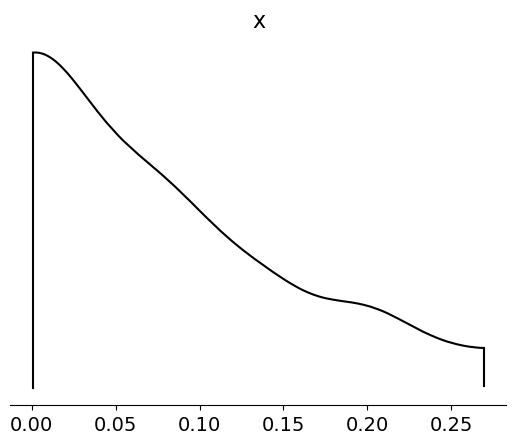

In [28]:
p_treat0, p_treat1 = (
    logistic(prior_sample_4["prior"]["a"] + prior_sample_4["prior"]["b"].sel(b_dim_0=0)),
    logistic(prior_sample_4["prior"]["a"] + prior_sample_4["prior"]["b"].sel(b_dim_0=1)),
)

az.plot_density(
    np.abs(p_treat0 - p_treat1).values,
    group="prior",
    colors=["k"],
    point_estimate=None
)

Observamos estas previas están concentradas en bajas diferencias absolutas. La diferencia priomedio es:

In [30]:
# Diferencia absoluta promedio
np.abs(p_treat0 - p_treat1).mean().values

array(0.10184142)

Al rededor de 10%. Diferencias grandes son menos plausibles.

Con esto tenemos nuestro modelo completo, y podemos dar el paso de ejecutarlo a cabalidad:

In [32]:
# Modelo final
with pm.Model() as final_model:
    a = pm.Normal("a", 0, 1.5, shape=7)
    b = pm.Normal("b", 0, 0.5, shape=4)
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(
            a[chimp_data["actor"].values]
            + b[chimp_data["treatment"].values]
        )
    )
    L = pm.Bernoulli(
        "pulled_left",
        p,
        observed=chimp_data["pulled_left"].values
    )

    idata_final = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [33]:
# Summary
az.summary(
    idata_final,
    kind="stats",
    hdi_prob=0.89,
    var_names=["a", "b"]
)

,mean,sd,hdi_5.5%,hdi_94.5%
a[0],-0.465,0.327,-0.988,0.063
a[1],3.897,0.782,2.581,5.039
a[2],-0.755,0.338,-1.269,-0.189
a[3],-0.758,0.326,-1.286,-0.260
a[4],-0.457,0.330,-0.959,0.089
a[5],0.470,0.326,-0.052,0.977
a[6],1.944,0.416,1.309,2.611
b[0],-0.035,0.285,-0.477,0.418
b[1],0.494,0.284,0.042,0.960
b[2],-0.377,0.283,-0.816,0.091


En este punto tendremos que trabajar un poco para interpretar estos parámetros.

Los primeros 7 parámetros son los "interceptos" únicos de cada chimpancé. Cada uno de ellos expresa la tendancia natural de cada animal para jalar la palanca izquierda:

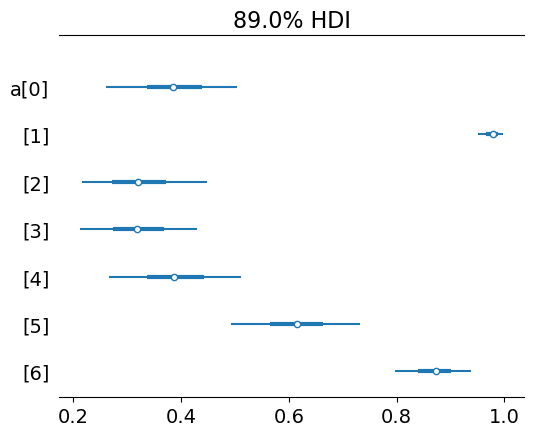

In [34]:
# Plot forest
az.plot_forest(
    idata_final,
    var_names=["a"],
    transform=logistic,
    combined=True,
    hdi_prob=0.89
);

Observamos que los chimpancés 0, 2, 3, y 4 tienen una preferencia sobre la palanca derecha. Por otra parte los chimpancés 1 y 6 prefieren la palanca izquierda. El chimpancé 1 tiene una preferencia total mente marcada. En efecto, si observamos los datos:

In [35]:
# Datos de palanca para actor 1
chimp_data.loc[chimp_data["actor"] == 1, "pulled_left"].unique()

array([1])

Observamos que hay diferencias muy marcadas entre los actores en sus tendencias naturales de qué palanca levantar. Este tipo de situaciones hacen complejo el análisis de experimentos sociales.

Ahora, analicemos el efecto de los tratamientos:

| `prosoc_left` | `condition` | Explicación:                                          |
| ------------- | ----------- | ----------------------------------------------------- |
|       0       |      0      | Dos elementos de comida a la derecha, sin compañero   |
|       1       |      0      | Dos elementos de comida a la izquierda, sin compañero |
|       0       |      1      | Dos elementos de comida a la derecha, con compañero   |
|       1       |      1      | Dos elementos de comida a la izquierda, con compañero |

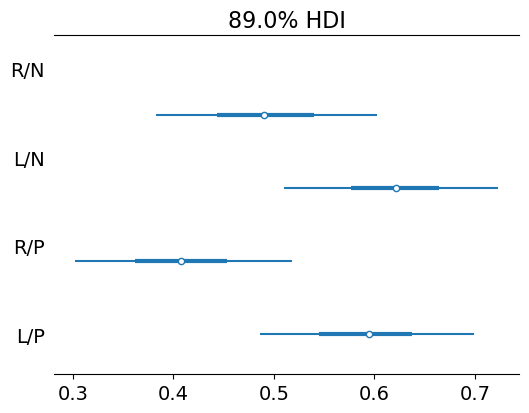

In [36]:
# Plot forest
az.plot_forest(
    idata_final,
    var_names=["b"],
    transform=logistic,
    combined=True,
    hdi_prob=0.89
);
plt.yticks(labels=["R/N", "L/N", "R/P", "L/P"], ticks=range(3, -1, -1));

En este caso, las etiquetas de los tratamientos indican el lado donde se encuentran los dos platos de comida (opción pro-social) y si hay un compañero del otro lado. Por ejemplo, R/N significa que los dos platos de comida están del lado derecho y que no hay compañero.

Recordemos que la expectativa está en encontrar evidencia si los chimpancés eligen la opción pro-social (compartir comida) cuando un compañero está presente. Esto implica comparar $\beta_0$ (R/N) con $\beta_2$ (R/P) y $\beta_1$ (L/N) con $\beta_3$ (L/P):

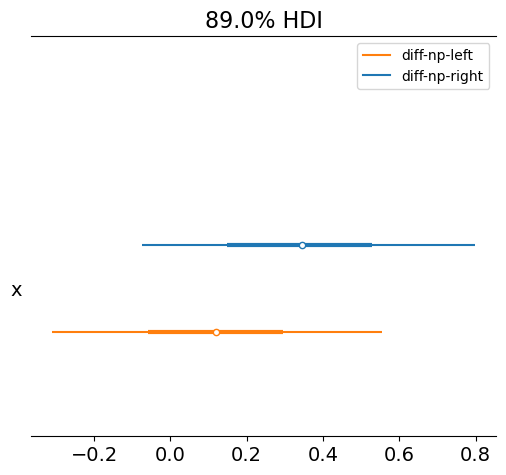

In [37]:
db02 = (
    idata_final.posterior["b"].sel(b_dim_0=0)
    - idata_final.posterior["b"].sel(b_dim_0=2)
)
db13 = (
    idata_final.posterior["b"].sel(b_dim_0=1)
    - idata_final.posterior["b"].sel(b_dim_0=3)
)
az.plot_forest(
    [db02.values, db13.values],
    model_names=["diff-np-right", "diff-np-left"],
    combined=True,
    hdi_prob=0.89
);

Acá lo que observamos es:

> `diff-np-right`: corresponde a la diferencia entre no compañero/compañero cuando la comida está a la derecha.

En este caso, una diferencia más grande (positiva) evidenciaría que los chimpancés levantaron más **la palanca derecha** en la presencia de un compañero. Vemos una débil evidencia de que la diferencia es positiva, pero el intervalo de compatibilidad es bastante amplio.

Del otro lado:

> `diff-np-left`: corresponde a la diferencia entre no compañero/compañero cuando la comida está a la izquierda.

En este caso, una diferencia más pequeña (negativa) evidenciaría que los chimpancés levantaron más **la palanca izquierda** en la presencia de un compañero. Este no es el caso. Vemos que el intervalo de compatibilidad es amplio, y casi centrado en cero.